# Demo for prosperity increase prediction model

-Muhan Zhang

In [344]:
import pandas as pd
import numpy as np 
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pickle
import torch 
from torch.utils.data import Dataset, DataLoader

Read the data in excel file and process the data. In this model, we are predicting prosperity score increase for every 5 years. 

In [314]:
sheets = ['Trade Freedom time', 'Investment Freedom time', "Women's Economic freedom time", 'Constraints on Government time', 'Political Rights time', 'Civil Liberties time', 'Judicial Effectiveness time', 'Efficient Judiciary time', 'Civil Justice time', 'Criminal Justice time', ' Government Integrity time', 'Perceptions of Corruption time', 'Absence of Corruption time', 'Public Disclosure time', 'State Capacity time', 'Order and Security time', 'Regulatory Effectivness time', ' Prosperity Index time']
x = []



for sheet in sheets:
    df = pd.read_excel("Freedom-and-Prosperity-Indexes-Full-Data-Set.xlsx", sheet_name=sheet)
    
    
    for column in df.columns:
        if "2021" in column and "raw" not in column:
            x2021 = column 
        if "2016" in column and "raw" not in column:
            x2016 = column 
        if "2011" in column and "raw" not in column:
            x2011 = column 
        if "2006" in column and "raw" not in column:
            x2006 = column 
        
    tempX = list(df[x2021]) + list(df[x2016]) + list(df[x2011]) + list(df[x2006])
    x.append(tempX)
    
x = np.array(x)
x = x.T

Since a decision tree model is only valid for predicting discrete values, we want to classify prosperity scores increasse into reasonable categories. To accomplish this goal, we make baisc statistical inferences and plot the data. 

In [315]:
y_mean = np.mean(x[:, -1])
y_std = np.std(x[:, -1])
y_median = np.median(x[:, -1])
print(f"median: {np.median(x[:, -1])}, mean: {np.mean(x[:, -1])}, maximum: {np.max(x[:, -1])}, min: {np.min(x[:, -1])}, std: {np.std(x[:, -1])}")

median: 48.381768214341605, mean: 50.568302204383635, maximum: 98.62843786656723, min: 15.468436008053452, std: 19.048045924210264


Text(0.5, 1.0, 'Prosperity scores increase value scatter plots')

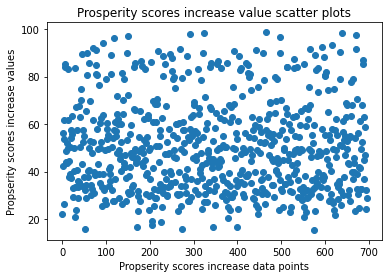

In [316]:
plot = x[:, -1]
x_plot= range(len(plot)) # [0, 1, 2, ..., n-1]
y_plot = plot
plt.scatter(x_plot, y_plot)
plt.xlabel("Propserity scores increase data points")
plt.ylabel("Propserity scores increase values")
plt.title("Prosperity scores increase value scatter plots")

The distribution of the data are almost normal distribution, with means only little above 0. In light of these observations, we use standard deviation as any label interval:
1. below -2.38 is 1
2. -2.38 to 0 is 2
3. 0 to 2.38 is 3
4. above -2.38 is 4

The next step is to map the values into these categories

In [317]:
count1 = 0
count2 = 0
count3 = 0

for i in range(x.shape[0]):
    #print(x[i,-1])
    
    if x[i,-1] <= 50:

        x[i,-1] = 1
        count1 += 1
    elif x[i,-1] < 75 and x[i,-1] >= 50:

        x[i,-1] = 2
        count2 += 1
    else:
        x[i,-1] = 3
        count3+= 1
print(f"label1: {count1}, label2: {count2}, label3: {count3}")

label1: 384, label2: 213, label3: 99


Noticing there are "Nan" in dataset, we first have to remove them, and split the dataset into training set and testing set. We use the default 4:1 ratio. 

In [318]:
x = x[~np.isnan(x).any(axis=1)]
test, train = train_test_split(x, test_size=0.8, random_state=25)
x_train, y_train = train[:,:-1], train[:,-1] 
x_test, y_test = test[:,:-1], test[:,-1]

print(f"variable training dimension:{x_train.shape}\nlabel training dimension{y_train.shape}\nvariable testing dimension{y_test.shape}\nlabel testing dimension{x_test.shape}")

variable training dimension:(395, 17)
label training dimension(395,)
variable testing dimension(98,)
label testing dimension(98, 17)


Next, we proceed with the training 

In [319]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

We visualize our decision tree model. 

[Text(198.7875, 208.38, 'X[14] <= 47.667\ngini = 0.614\nsamples = 395\nvalue = [192, 139, 64]'),
 Text(117.84078947368421, 190.26, 'X[2] <= 79.375\ngini = 0.345\nsamples = 235\nvalue = [183, 52, 0]'),
 Text(90.30789473684212, 172.14, 'X[3] <= 0.638\ngini = 0.113\nsamples = 133\nvalue = [125, 8, 0]'),
 Text(66.07894736842105, 154.01999999999998, 'X[13] <= 0.243\ngini = 0.075\nsamples = 128\nvalue = [123, 5, 0]'),
 Text(44.05263157894737, 135.89999999999998, 'X[7] <= 65.625\ngini = 0.034\nsamples = 115\nvalue = [113, 2, 0]'),
 Text(26.431578947368422, 117.77999999999999, 'X[9] <= 25.21\ngini = 0.018\nsamples = 109\nvalue = [108, 1, 0]'),
 Text(17.621052631578948, 99.66, 'X[12] <= 23.839\ngini = 0.1\nsamples = 19\nvalue = [18, 1, 0]'),
 Text(8.810526315789474, 81.53999999999999, 'gini = 0.0\nsamples = 18\nvalue = [18, 0, 0]'),
 Text(26.431578947368422, 81.53999999999999, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(35.242105263157896, 99.66, 'gini = 0.0\nsamples = 90\nvalue = [90,

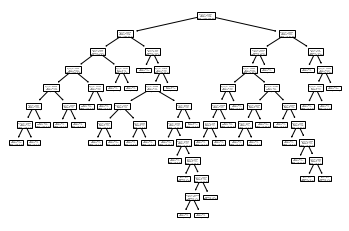

In [320]:
tree.plot_tree(clf)

Next, we conduct post pruning to avoid overfitting. The idea of post pruning is to continuously delete the node with the lowest impurity (least abale to classify data) until the test data accuracy is maximized. The following creates a list of model where for each element, the previous has one more node. 

In [321]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Iterate through each models and calculate the training and testing scores

In [322]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
    print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1])
)

Number of nodes in the last tree is: 77 with ccp_alpha: 0.18940541613966666
Number of nodes in the last tree is: 73 with ccp_alpha: 0.18940541613966666
Number of nodes in the last tree is: 69 with ccp_alpha: 0.18940541613966666
Number of nodes in the last tree is: 61 with ccp_alpha: 0.18940541613966666
Number of nodes in the last tree is: 59 with ccp_alpha: 0.18940541613966666
Number of nodes in the last tree is: 57 with ccp_alpha: 0.18940541613966666
Number of nodes in the last tree is: 55 with ccp_alpha: 0.18940541613966666
Number of nodes in the last tree is: 51 with ccp_alpha: 0.18940541613966666
Number of nodes in the last tree is: 47 with ccp_alpha: 0.18940541613966666
Number of nodes in the last tree is: 45 with ccp_alpha: 0.18940541613966666
Number of nodes in the last tree is: 41 with ccp_alpha: 0.18940541613966666
Number of nodes in the last tree is: 37 with ccp_alpha: 0.18940541613966666
Number of nodes in the last tree is: 31 with ccp_alpha: 0.18940541613966666
Number of no

As we can observe from the graph, the model performs best when it has two nodes. We pick this as our final model. 

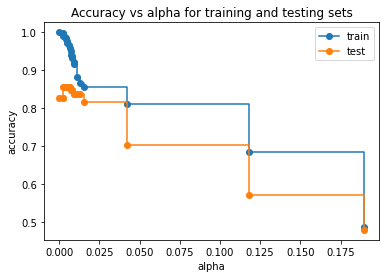

In [323]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

The following is our final model. The accuracy is not as well as we are expecting. This is possibly due to the lack of data and the lack of correlation between these variables. Finally, we visualize and store the model. 

In [324]:
clf = clfs[-13]

tree_training_accuracy = clf.score(x_train, y_train)
tree_testing_accuracy = clf.score(x_test, y_test)
tree_training_f1 = f1_score(y_train, clf.predict(x_train), average='weighted')
tree_testing_f1 = f1_score(y_test, clf.predict(x_test), average='weighted')
print(f"tree_training_accuracy: {tree_training_accuracy}")
print(f"tree_testing_accuracy: {tree_testing_accuracy}")
print(f"tree_training_f1: {tree_training_f1}")
print(f"tree_testing_f1: {tree_testing_f1}")

tree_training_accuracy: 0.959493670886076
tree_testing_accuracy: 0.8571428571428571
tree_training_f1: 0.9597247482151436
tree_testing_f1: 0.8592295569254095


[Text(177.8625, 203.85, 'X[14] <= 47.667\ngini = 0.614\nsamples = 395\nvalue = [192, 139, 64]'),
 Text(76.72500000000001, 176.67000000000002, 'X[2] <= 79.375\ngini = 0.345\nsamples = 235\nvalue = [183, 52, 0]'),
 Text(41.85, 149.49, 'X[3] <= 0.638\ngini = 0.113\nsamples = 133\nvalue = [125, 8, 0]'),
 Text(27.900000000000002, 122.31, 'X[13] <= 0.243\ngini = 0.075\nsamples = 128\nvalue = [123, 5, 0]'),
 Text(13.950000000000001, 95.13, 'gini = 0.034\nsamples = 115\nvalue = [113, 2, 0]'),
 Text(41.85, 95.13, 'X[2] <= 73.125\ngini = 0.355\nsamples = 13\nvalue = [10, 3, 0]'),
 Text(27.900000000000002, 67.94999999999999, 'gini = 0.0\nsamples = 10\nvalue = [10, 0, 0]'),
 Text(55.800000000000004, 67.94999999999999, 'gini = 0.0\nsamples = 3\nvalue = [0, 3, 0]'),
 Text(55.800000000000004, 122.31, 'gini = 0.48\nsamples = 5\nvalue = [2, 3, 0]'),
 Text(111.60000000000001, 149.49, 'X[14] <= 31.0\ngini = 0.491\nsamples = 102\nvalue = [58, 44, 0]'),
 Text(97.65, 122.31, 'gini = 0.0\nsamples = 32\nvalue

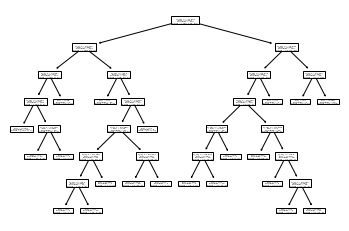

In [325]:
tree.plot_tree(clf)

## Random Forest

Initialize and fit the model

In [326]:
clf_random=RandomForestClassifier(n_estimators=300)
clf_random.fit(x_train,y_train)
print(clf_random.score(x_train, y_train))
print(clf_random.score(x_test, y_test))

1.0
0.8673469387755102


Performance of the model 

In [327]:
forest_training_accuracy = clf_random.score(x_train, y_train)
forest_testing_accuracy = clf_random.score(x_test, y_test)
forest_training_f1 = f1_score(y_train, clf_random.predict(x_train), average='weighted')
forest_testing_f1 = f1_score(y_test, clf_random.predict(x_test), average='weighted')
print(f"forest_training_accuracy: {forest_training_accuracy}")
print(f"forest_testing_accuracy: {forest_testing_accuracy}")
print(f"forest_training_f1: {forest_training_f1}")
print(f"forest_testing_f1: {forest_testing_f1}")

forest_training_accuracy: 1.0
forest_testing_accuracy: 0.8673469387755102
forest_training_f1: 1.0
forest_testing_f1: 0.8641338375543921


## GradientBoosting

Initialize and fit the model

In [328]:
clf_gradientBoosting = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_gradientBoosting.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

Performance of the model 

In [329]:
gradient_training_accuracy = clf_gradientBoosting.score(x_train, y_train)
gradient_testing_accuracy = clf_gradientBoosting.score(x_test, y_test)
gradient_training_f1 = f1_score(y_train, clf_gradientBoosting.predict(x_train), average='weighted')
gradient_testing_f1 = f1_score(y_test, clf_gradientBoosting.predict(x_test), average='weighted')
print(f"gradient_training_accuracy: {gradient_training_accuracy}")
print(f"gradient_testing_accuracy: {gradient_testing_accuracy}")
print(f"gradient_training_f1: {gradient_training_f1}")
print(f"gradient_testing_f1: {gradient_testing_f1}")

gradient_training_accuracy: 1.0
gradient_testing_accuracy: 0.8775510204081632
gradient_training_f1: 1.0
gradient_testing_f1: 0.876062037718313


## Neural Network

Establish the data loader

In [330]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    self.X = torch.from_numpy(X_train.astype(np.float32))
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
  def __len__(self):
    return self.len


traindata = Data(x_train, y_train)
batch_size = 3
trainloader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=0)

Setup Neural Network (output_dim is set to 4 because 3 would occur index error; don't why that is the case...). Additionally, only 1 hidden layer is created due to the lack of data which would possibly lead to overfitting. 

In [331]:
import torch.nn as nn
# number of features (len of X cols)
input_dim = 17
# number of hidden layers
hidden_layers = 1
# number of classes (unique of y)
output_dim = 4
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_layers)
    self.linear2 = nn.Linear(hidden_layers, output_dim)
  def forward(self, x):
    x = torch.sigmoid(self.linear1(x))
    x = self.linear2(x)
    return x

In [332]:
clf_network = Network()
print(clf_network.parameters)

<bound method Module.parameters of Network(
  (linear1): Linear(in_features=17, out_features=1, bias=True)
  (linear2): Linear(in_features=1, out_features=4, bias=True)
)>


Setup loss function 

In [333]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf_network.parameters(), lr=0.1)

Start training

In [334]:
epochs = 50
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()
    # forward propagation
    outputs = clf_network(inputs)
    loss = criterion(outputs, labels)
    # backward propagation
    loss.backward()
    # optimize
    optimizer.step()
    running_loss += loss.item()
  # display statistics
  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.5f}')


[1,   132] loss: 0.07544
[2,   132] loss: 0.06973
[3,   132] loss: 0.06877
[4,   132] loss: 0.06835
[5,   132] loss: 0.06818
[6,   132] loss: 0.06774
[7,   132] loss: 0.06778
[8,   132] loss: 0.06799
[9,   132] loss: 0.06755
[10,   132] loss: 0.06791
[11,   132] loss: 0.06747
[12,   132] loss: 0.06772
[13,   132] loss: 0.06769
[14,   132] loss: 0.06765
[15,   132] loss: 0.06762
[16,   132] loss: 0.06787
[17,   132] loss: 0.06777
[18,   132] loss: 0.06753
[19,   132] loss: 0.06735
[20,   132] loss: 0.06746
[21,   132] loss: 0.06764
[22,   132] loss: 0.06758
[23,   132] loss: 0.06751
[24,   132] loss: 0.06747
[25,   132] loss: 0.06747
[26,   132] loss: 0.06744
[27,   132] loss: 0.06748
[28,   132] loss: 0.06765
[29,   132] loss: 0.06748
[30,   132] loss: 0.06751
[31,   132] loss: 0.06741
[32,   132] loss: 0.06744
[33,   132] loss: 0.06754
[34,   132] loss: 0.06737
[35,   132] loss: 0.06743
[36,   132] loss: 0.06745
[37,   132] loss: 0.06743
[38,   132] loss: 0.06743
[39,   132] loss: 0.0

Check for results. The neural network performed horribly. Possibly due to the lack of data.

In [340]:
testdata = Data(x_test, y_test)
testloader = DataLoader(testdata, batch_size=batch_size, 
                        shuffle=True, num_workers=0)

correct, total = 0, 0
c = []
p = []
# no need to calculate gradients during inference
with torch.no_grad():
  for data in testloader:
    inputs, labels = data
    # calculate output by running through the network
    outputs = clf_network(inputs)
    # get the predictions
    __, predicted = torch.max(outputs.data, 1)
    # update results
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
    p = p + list(predicted)
    c = c + list(labels)



network_testing_accuracy = correct / total
network_testing_f1 = f1_score(p, c, average='weighted')

p = []
c = []
correct, total = 0, 0
# no need to calculate gradients during inference
with torch.no_grad():
  for data in trainloader:
    inputs, labels = data
    # calculate output by running through the network
    outputs = clf_network(inputs)
    # get the predictions
    __, predicted = torch.max(outputs.data, 1)
    # update results
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
    p = p + list(predicted)
    c = c + list(labels)

network_training_accuracy = correct / total
network_training_f1 = f1_score(p, c, average='weighted')

print(f"network_training_accuracy: {network_training_accuracy}")
print(f"network_testing_accuracy: {network_testing_accuracy}")
print(f"network_training_f1: {network_training_f1}")
print(f"network_testing_f1: {network_testing_f1}")

network_training_accuracy: 0.4860759493670886
network_testing_accuracy: 0.47959183673469385
network_training_f1: 0.6541737649063031
network_testing_f1: 0.6482758620689655


## Conclusion

Finally, we compare the performances of all the machine learning algorithm we have employed: decision tree, random forest, gradient boosting, and neural network with 1 hidden layer. Neural network did most poorly possibly due to lack of data and incorrect parameter settings. It is surpuring that decision tree performed much better than random forest and neural network, which are much more sophisticated algorithm. This finding shows that with simpler dataset and a small amount of training data, simpler model may be more effective than more complicated ones. 

In [341]:

# assign data
mydata = [
    ["decision tree", str(tree_training_accuracy), str(tree_testing_accuracy), str(tree_training_f1), str(tree_testing_f1)], 
    ["random forest", str(forest_training_accuracy), str(forest_testing_accuracy), str(forest_training_f1), str(forest_testing_f1)], 
    ["gradient boosting", str(gradient_training_accuracy), str(gradient_testing_accuracy), str(gradient_training_f1), str(gradient_testing_f1)], 
    ["neural network", str(network_training_accuracy), str(network_testing_accuracy), str(network_training_f1), str(network_testing_f1)]
]
 
# create header
result = pd.DataFrame(mydata, columns = ["Model", "training data accuracy", "testing data accuracy", "training data f1 score", "testing data f1 score"])
print(result.head())


               Model training data accuracy testing data accuracy  \
0      decision tree      0.959493670886076    0.8571428571428571   
1      random forest                    1.0    0.8673469387755102   
2  gradient boosting                    1.0    0.8775510204081632   
3     neural network     0.4860759493670886   0.47959183673469385   

  training data f1 score testing data f1 score  
0     0.9597247482151436    0.8592295569254095  
1                    1.0    0.8641338375543921  
2                    1.0     0.876062037718313  
3     0.6541737649063031    0.6482758620689655  


## Miscellaneous 

In [342]:
#This function is for saving our loading model
def save_model(model_name='finalized_model.sav'):
    pickle.dump(clf, open(filename, 'wb'))
    return 
    
#This function is for later our loading model
def load_model(model_name='finalized_model.sav'):
    loaded_model = pickle.load(open(filename, 'rb'))
    return 

def save_table(table, name = "result.csv"):
    table.to_csv(name)
    return

In [343]:
save_table(result)

### References 
https://scikit-learn.org

https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2